Oct 7

1. get #GCs by using different random set of parameters from MCMC -> check if it is consistent with the 1-sigma error that I plot, also plot the two lines of +-1sigma to see;

3. divide data into mass bins, calculate the mean and error, plot it;

2. Plot only #GCs of central gal.s vs their M_h;

4. use Planck Pk, generate results with M_form change 10^7 - 10^9; z_form change 6-12;


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from astropy.table import Table

In [4]:
import astropy.io.fits as fits

In [5]:
import corner

In [6]:
import emcee

In [7]:
from scipy.optimize import minimize

In [8]:
from IPython.display import display, Math

do MCMC

In [9]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [10]:
y = data['NGCs']
x = data['Mag z']
yerr = data['err GC']

In [11]:
a = np.argwhere(~np.isnan(x)) #find idx of non nan values in Mag z

In [12]:
x    = x[a]
y    = y[a]
yerr = yerr[a]

In [13]:
x    = x.reshape((len(a)))
y    = y.reshape((len(a)))
yerr = yerr.reshape((len(a)))

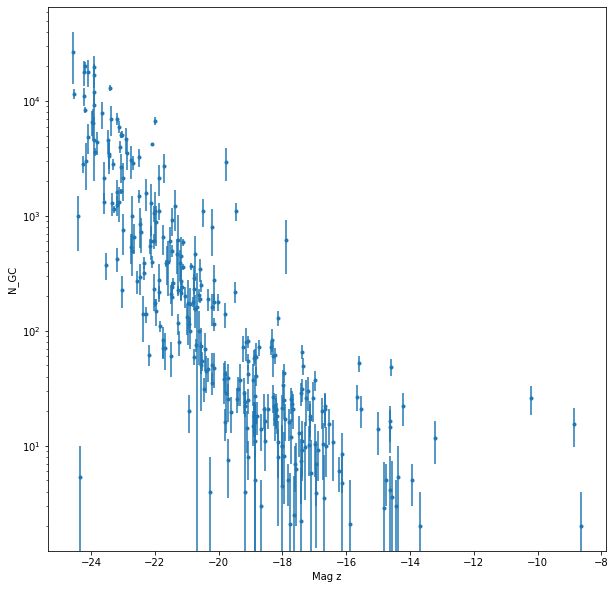

In [14]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.xlabel("Mag z")
plt.ylabel("N_GC");

Try with the model as Moster

$y(x) = a\left(\frac{x}{M_1}\right)^{\alpha} + b\left(\frac{x}{M_1}\right)^{\beta}$

In [15]:
def model(theta, x):
    a, alpha, b, beta, M1, log_f = theta
    model = a*(x/M1)**alpha + b*(x/M1)**beta
    return model

In [16]:
def log_likelihood(theta, x, y, yerr):
    a, alpha, b, beta, M1, log_f = theta
    sigma2 = yerr**2 + model(theta,x)**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(theta,x)) ** 2 / sigma2 + np.log(sigma2))


In [17]:
#initial values (guess)
a_ini     = 5
alpha_ini = 2 
b_ini     = 8
beta_ini  = 2
M1_ini    = -20
f_ini     = 0.2 
ini  = np.array([a_ini, alpha_ini, b_ini, beta_ini, M1_ini, np.log(f_ini)]) 
ndim = len(ini)

In [18]:
np.random.seed(42)
nll     = lambda *args: -log_likelihood(*args)
initial = ini + 1e-3 * np.random.randn(ndim)
soln    = minimize(nll, initial, args=(x, y, yerr))
a_ml, alpha_ml, b_ml, beta_ml, M1_ml, log_f_ml = soln.x

theta_ml = [a_ml, alpha_ml, b_ml, beta_ml, M1_ml, log_f_ml]

print("Maximum likelihood estimates:")
print("a     = {0:.3f}".format(a_ml))
print("alpha = {0:.3f}".format(alpha_ml))
print("b     = {0:.3f}".format(b_ml))
print("beta  = {0:.3f}".format(beta_ml))
print("M1    = {0:.3f}".format(M1_ml))
print("f     = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
a     = 15.651
alpha = 0.865
b     = 19.523
beta  = 27.113
M1    = -19.223
f     = 0.799


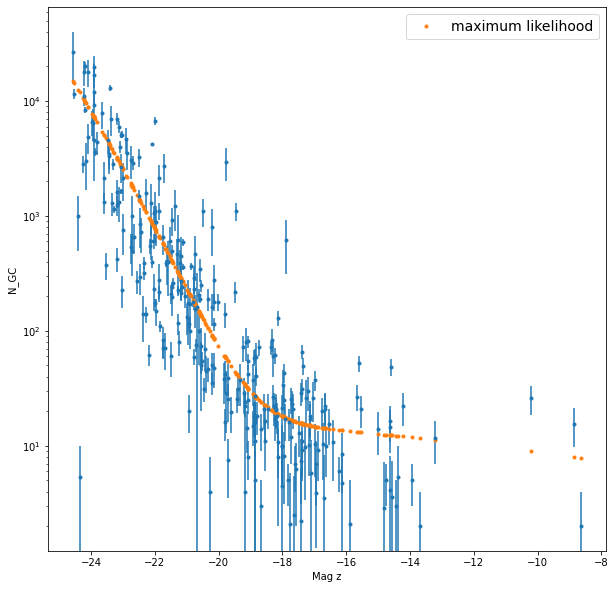

In [19]:
plt.figure(figsize=(10,10))
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.plot(x, model(theta_ml, x), '.', label = 'maximum likelihood')
plt.legend(fontsize=14)
plt.xlabel("Mag z")
plt.yscale('log')
plt.ylabel("N_GC");

In [20]:
def log_prior(theta):
    a, alpha, b, beta, M1, log_f = theta
    if 0. < a < 30. and -5 < alpha < 5 and 0 < b < 30000 and 0 < beta < 40. and -25 < M1 < -15 and -10.0 < log_f < 10:
        return 0.0
    return -np.inf

In [21]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [22]:
nwalkers = 240 # no. of paramters x 40
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
niter = 70000  # nwalkers x 1000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, niter, progress=True);

You must install the tqdm library to use progress indicators with emcee


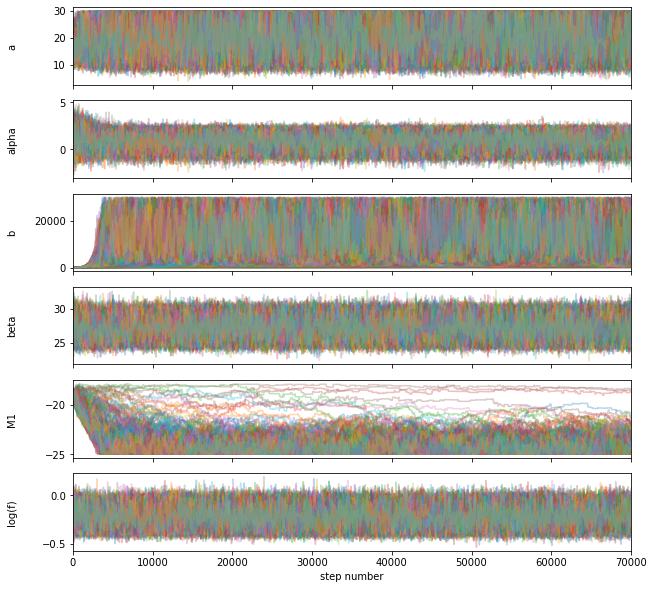

In [23]:
fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["a", 'alpha', "b", 'beta', 'M1', "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1400;
tau: [ 381.14188465  334.65011598 2040.03178293  288.52899641 3687.59363539
  264.19738195]

In [25]:
flat_samples = sampler.get_chain(discard=100, thin=500, flat=True) #thin the samples ~ 0.5 of autocorr time
print(flat_samples.shape)

(33360, 6)


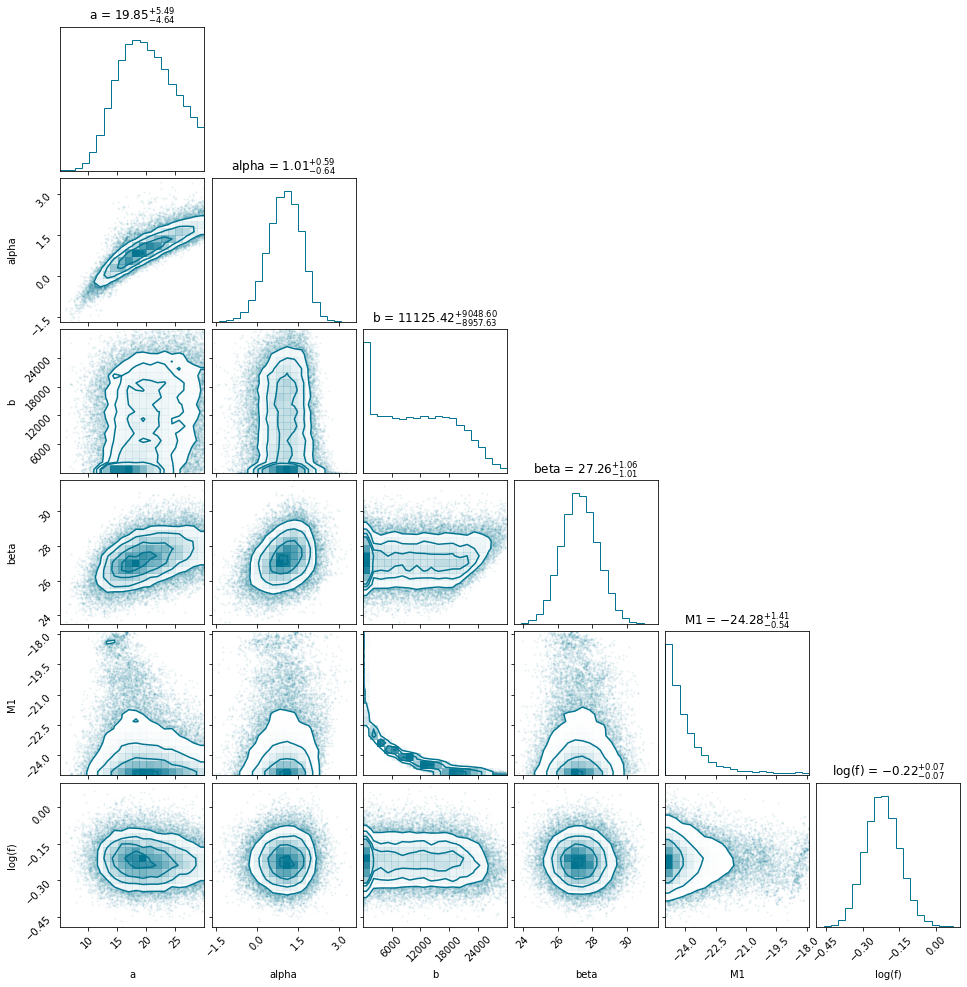

In [26]:
fig = corner.corner(flat_samples, show_titles=True,labels=labels, color='#047591')
#fig.savefig('corner_constrain.pdf')

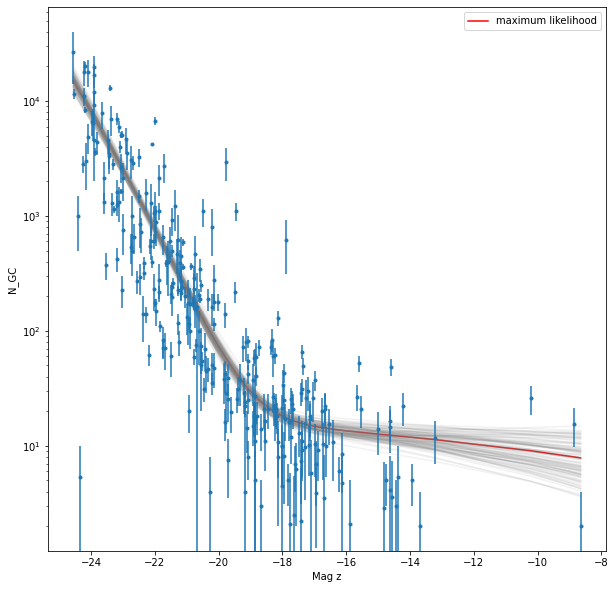

In [27]:
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize=(10,10))
plt.yscale('log')
models = []
x2 = np.sort(x)
plt.plot(x2, model(theta_ml, x2), 'r-', label = 'maximum likelihood')
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x2, model(sample,x2), color='grey', alpha = 0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.xlabel("Mag z")
plt.ylabel("N_GC")
plt.legend()
#plt.savefig('parameters_100.pdf')

In [28]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

1. get #GCs by using different random set of parameters from MCMC -> check if it is consistent with the 1-sigma error that I plot, also plot the two lines of +-1sigma to see;

In [29]:
theta = np.zeros(ndim)
theta_plus = np.zeros(ndim)
theta_minus = np.zeros(ndim)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    theta[i] = mcmc[1]
    theta_plus[i] = theta[i] + q[1]
    theta_minus[i] = theta[i] - q[0]

In [30]:
path='/data/lemn/DESIdata/'

In [31]:
#load Mag z
data = fits.getdata(path+'galaxies/DESIDR9_NGC_galaxy.fits')

In [32]:
Mag_z = data['M_zband']

In [33]:
Mag_z = np.sort(Mag_z)

In [34]:
N_GC = model(theta, Mag_z)

In [35]:
N_GC_plus= model(theta_plus, Mag_z)

In [36]:
N_GC_minus = model(theta_minus, Mag_z)

plot the mean and +-1sigma error lines

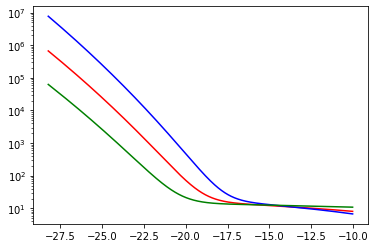

In [37]:
plt.yscale('log')
plt.plot(Mag_z, N_GC, 'r-')
plt.plot(Mag_z, N_GC_plus, 'b-')
plt.plot(Mag_z, N_GC_minus, 'g-')

generate #GCs at one Mag_z, using different parameter sets to see whether it is Gaussian or not

In [57]:
Mag_test = np.arange(-28,-10,0.5)
print(len(Mag_test))

36


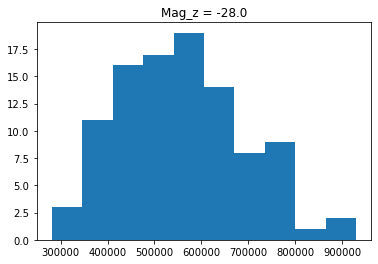

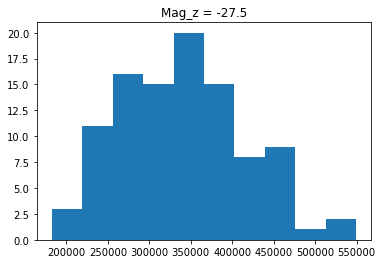

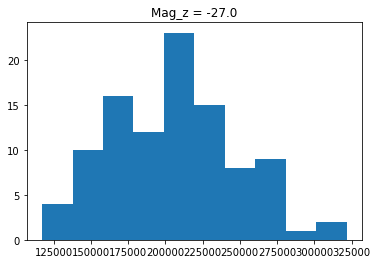

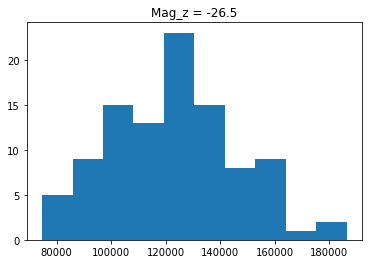

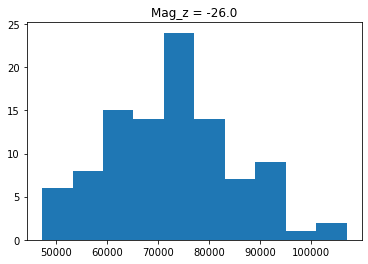

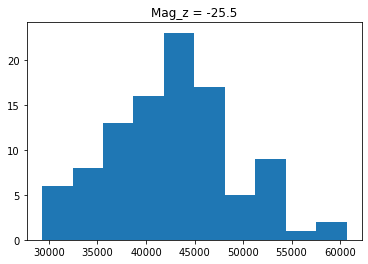

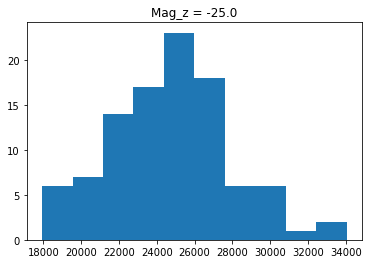

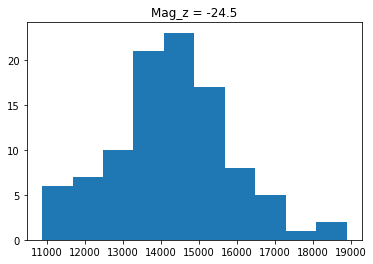

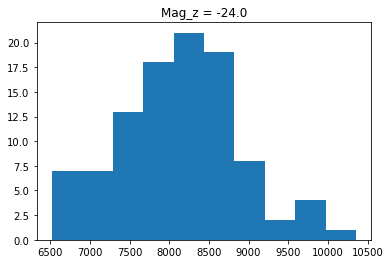

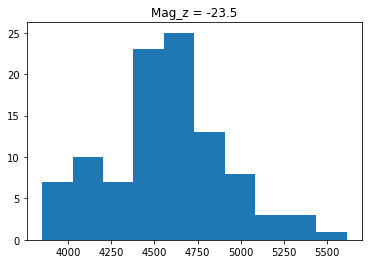

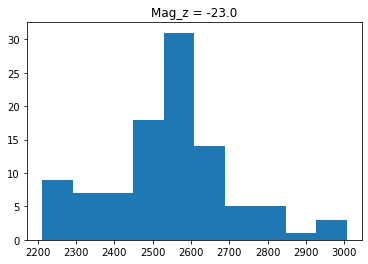

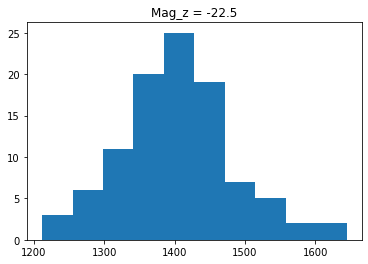

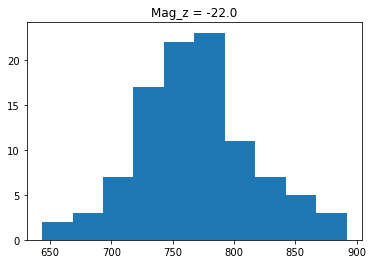

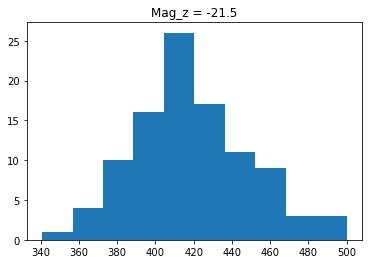

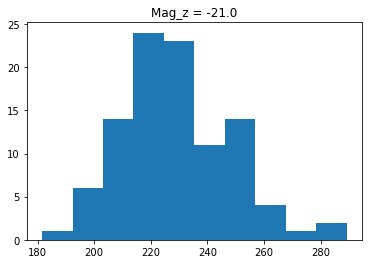

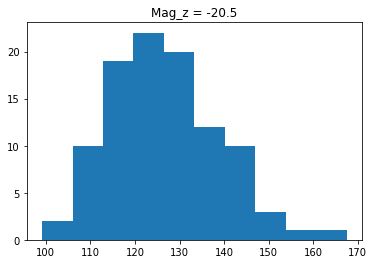

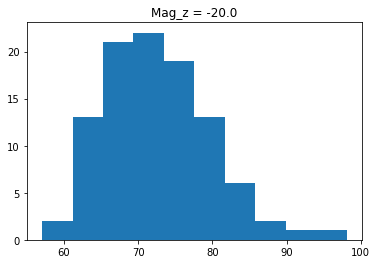

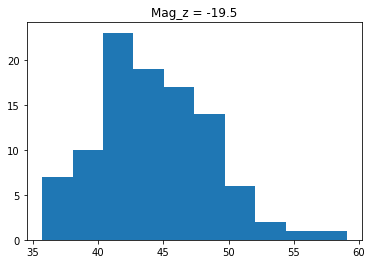

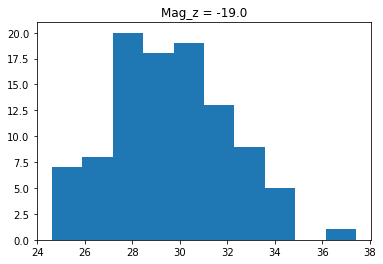

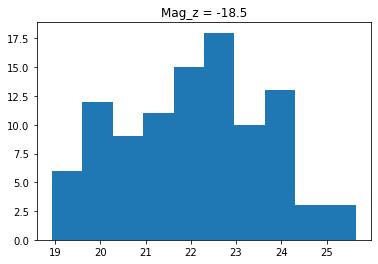

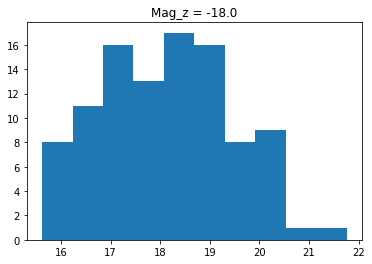

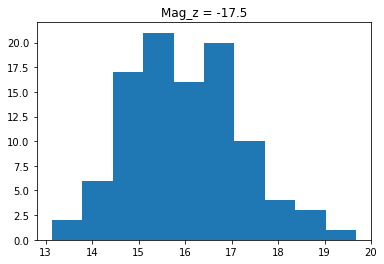

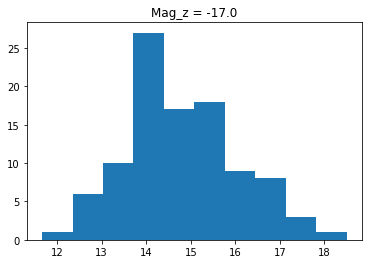

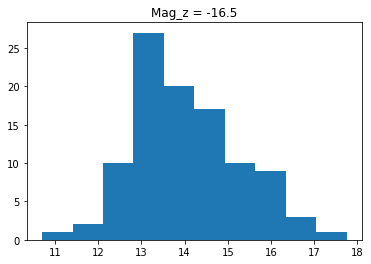

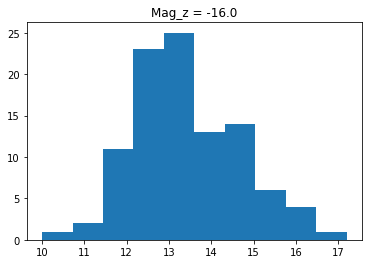

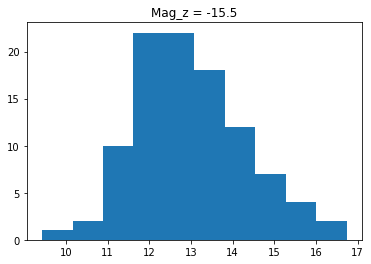

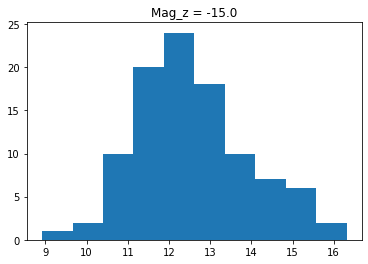

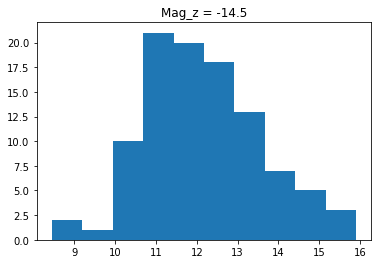

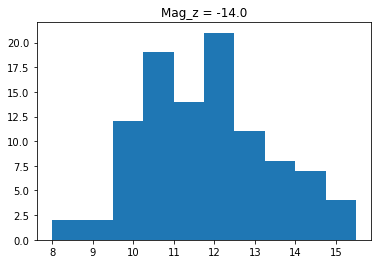

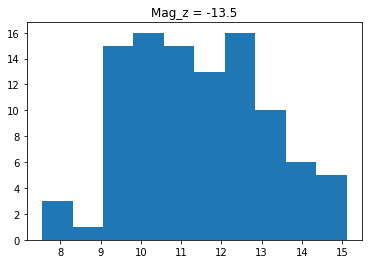

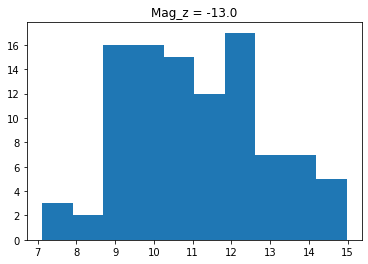

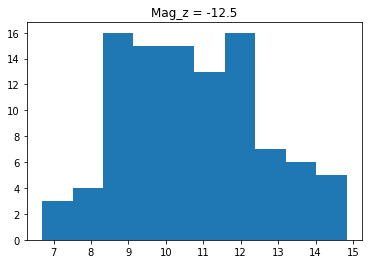

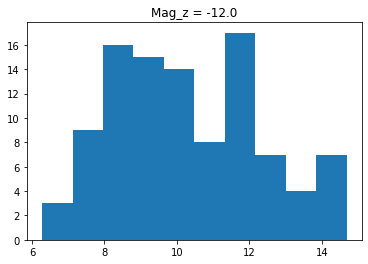

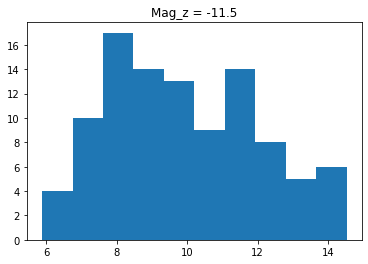

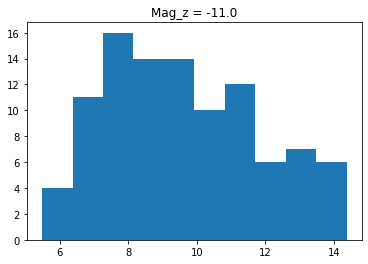

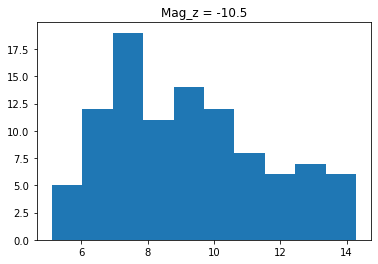

In [58]:
for j in range(0,len(Mag_test)):
    N_test = np.zeros(len(inds))
    i = 0
    for ind in inds:
        sample = flat_samples[ind]
        N_test[i] = model(sample,Mag_test[j])
        i+= 1
    plt.hist(N_test)
    plt.title('Mag_z = '+ str(Mag_test[j]))
    plt.show()

2. Plot only #GCs of central gal.s vs their M_h; to compare to EMOSAICS data (Reina-Campos 20)

In [59]:
data2 = fits.getdata(path+'members/iDESIDR9_NGC_1.fits')

In [62]:
hdul = fits.open(path+'members/iDESIDR9_NGC_1.fits')
hdul.info()
hdul[0].header[1]
hdul[1].columns

Filename: /data/lemn/DESIdata/members/iDESIDR9_NGC_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     12   67197600R x 2C   [D, D]   


ColDefs(
    name = 'gal ID'; format = 'D'
    name = 'groupID'; format = 'D'
)

In [ ]:
mem_id = data2['gal ID']
group_id = data2['group_id']
cen_check = data2['']